In [15]:
import sys
import os
sys.path.append("..") 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from src.preprocessing import Preprocessor
from src.lstm_forecasting import LSTMForecaster
from sklearn.metrics import mean_squared_error

# Pour ne pas afficher de warnings inutiles
import warnings
warnings.filterwarnings("ignore")

In [16]:
# champs_elysees_df = pd.read_csv('../data/traffic/champs_elysees.csv', sep=";")
convention_df = pd.read_csv('../data/traffic/convention.csv', sep=";")
# sts_peres_df = pd.read_csv('../data/traffic/sts_peres.csv', sep=";")

weather_df = pd.read_csv('../data/weather/weather_paris.csv')
holidays_df = pd.read_csv('../data/events/french_holidays.csv', sep=";")
football_matches_df = pd.read_csv('../data/events/football_matches_2024_2025.csv')

In [17]:
preprocessor = Preprocessor(df=convention_df)

# On applique ton pipeline de preprocessing
df_processed = preprocessor.fit_transform(holidays_df=holidays_df, weather_df=weather_df, sports_df=football_matches_df)

print("Preprocessed Data :", df_processed.shape)
display(df_processed.sample(5))


Preprocessed Data : (8627, 43)


,Identifiant arc,Libelle,Débit horaire,Taux d'occupation,Etat trafic,Identifiant noeud amont,Libelle noeud amont,Identifiant noeud aval,Libelle noeud aval,Etat arc,...,relative_humidity_2m (%),precipitation (mm),wind_speed_10m (km/h),weather_code (wmo code),surface_pressure (hPa),cloud_cover (%),apparent_temperature (°C),rain (mm),sport_event_name,is_sport_event
Date et heure de comptage,,,,,,,,,,,,,,,,,,,,,
2025-01-19 15:00:00,5671,Convention,626.000000,4.117780,Fluide,2937,Lecourbe-Convention,2973,Convention-Blomet,Invalide,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Ligue 1 : AS Saint-Étienne vs FC Nantes,True
2025-04-05 00:00:00,5671,Convention,696.765396,12.172577,Inconnu,2937,Lecourbe-Convention,2973,Convention-Blomet,Invalide,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2024-12-12 23:00:00,5671,Convention,339.000000,1.795560,Fluide,2937,Lecourbe-Convention,2973,Convention-Blomet,Invalide,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2024-10-06 03:00:00,5671,Convention,NaN,NaN,Inconnu,2937,Lecourbe-Convention,2973,Convention-Blomet,Invalide,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2024-10-13 00:00:00,5671,Convention,NaN,NaN,Inconnu,2937,Lecourbe-Convention,2973,Convention-Blomet,Invalide,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False


# LSTM Forecasting

In [18]:
forecaster = LSTMForecaster(
    seq_length= 168,  # 7 historical days
    pred_length=72,  # prediction 72h in advance
    lstm_units=64,
    dropout=0.2,
    use_weather=False,
    use_holidays=False,
    use_sport=False
)

# Preparation of sequences
X_train, X_test, y_train, y_test = forecaster.prepare_data(df_processed)

# Training
history = forecaster.train(
    X_train, y_train,
    X_test, y_test,
    epochs=5, batch_size=32
)


Epoch 1/5
181/181 ━━━━━━━━━━━━━━━━━━━━ 14s 64ms/step - loss: 0.0438 - val_loss: 0.0417
Epoch 2/5
181/181 ━━━━━━━━━━━━━━━━━━━━ 11s 62ms/step - loss: 0.0264 - val_loss: 0.0355
Epoch 3/5
181/181 ━━━━━━━━━━━━━━━━━━━━ 11s 61ms/step - loss: 0.0214 - val_loss: 0.0282
Epoch 4/5
181/181 ━━━━━━━━━━━━━━━━━━━━ 11s 60ms/step - loss: 0.0190 - val_loss: 0.0245
Epoch 5/5
181/181 ━━━━━━━━━━━━━━━━━━━━ 11s 59ms/step - loss: 0.0192 - val_loss: 0.0210


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
Débit horaire : RMSE = 188.22, Mean = 409.50, Relative error = 45.96%
Taux d'occupation : RMSE = 2.93, Mean = 3.78, Relative error = 77.60%


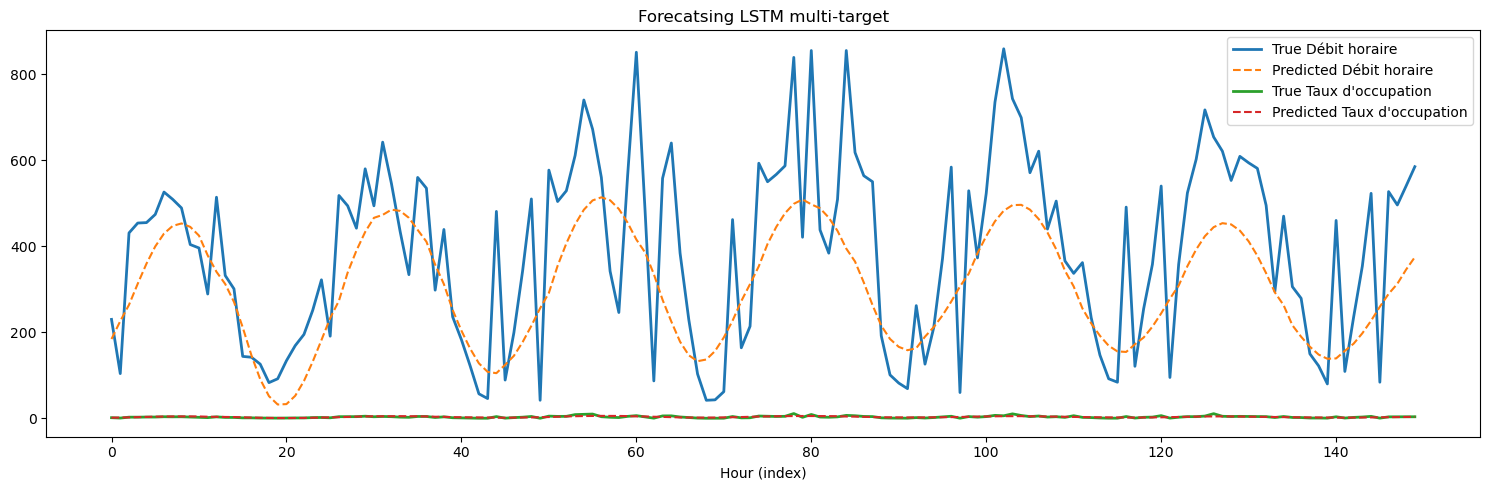

In [19]:
y_test_inv, y_pred_inv = forecaster.evaluate(X_test, y_test)

# Visualisation on the first 72 hours
forecaster.plot_predictions(y_test_inv, y_pred_inv, n_plot=150)

In [20]:
# Concaténer train + test pour la CV (on prend tout)
X_all = np.concatenate([X_train, X_test], axis=0)
y_all = np.concatenate([y_train, y_test], axis=0)

forecaster.time_series_cv(X_all, y_all, n_splits=5, epochs=5, batch_size=32)

Epoch 1/5
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - loss: 0.0804 - val_loss: 0.1116
Epoch 2/5
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step - loss: 0.0406 - val_loss: 0.0993
Epoch 3/5
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step - loss: 0.0370 - val_loss: 0.0878
Epoch 4/5
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - loss: 0.0326 - val_loss: 0.0903
Epoch 5/5
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step - loss: 0.0270 - val_loss: 0.0923
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
Débit horaire : RMSE = 205.99, Mean = 639.10, Relative error = 32.23%
Taux d'occupation : RMSE = 13.60, Mean = 15.17, Relative error = 89.67%
Epoch 1/5
76/76 ━━━━━━━━━━━━━━━━━━━━ 8s 72ms/step - loss: 0.0821 - val_loss: 0.0531
Epoch 2/5
76/76 ━━━━━━━━━━━━━━━━━━━━ 5s 67ms/step - loss: 0.0372 - val_loss: 0.0694
Epoch 3/5
76/76 ━━━━━━━━━━━━━━━━━━━━ 6s 73ms/step - loss: 0.0329 - val_loss: 0.0765
Epoch 4/5
76/76 ━━━━━━━━━━━━━━━━━━━━ 5s 67ms/step - loss: 0.0313 - val_loss: 0.0715
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step
Débit horaire : RMSE 

# XGBoost model

In [21]:
from src.xgb_forecasting import XGBoostModel

Train set: (1417, 6), Test set: (72, 6) (72 hours)
Débit horaire : RMSE = 204.49, Mean = 389.14, Relative Error = 52.55%
Taux d'occupation : RMSE = 3.39, Mean = 3.49, Relative Error = 97.20%


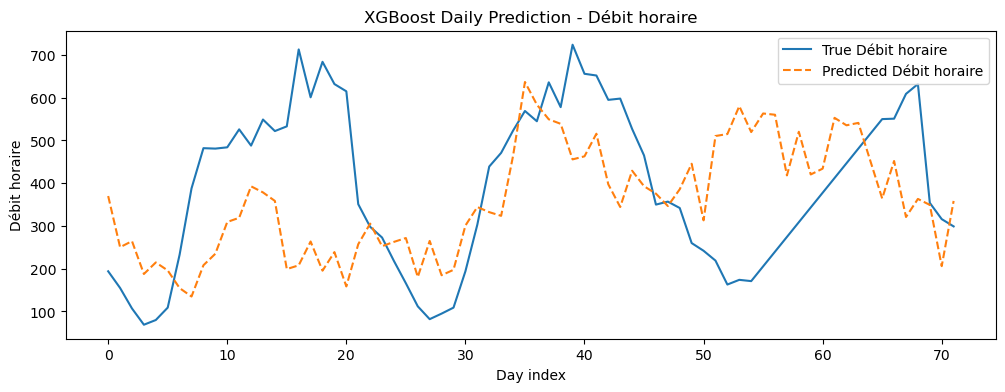

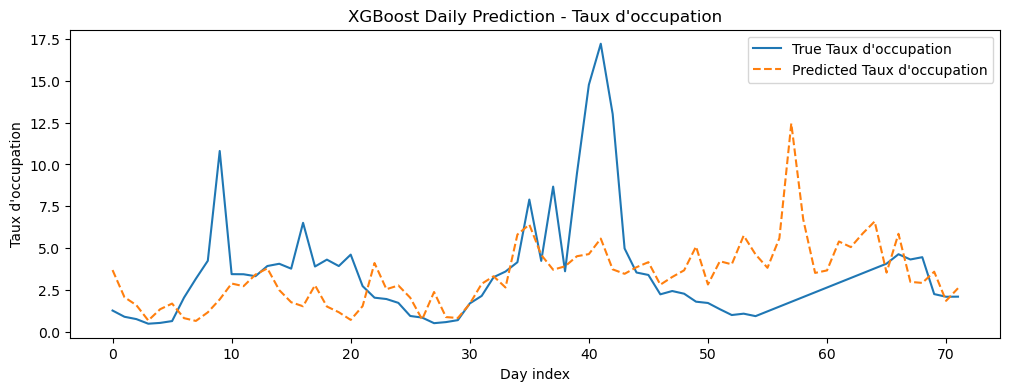

In [22]:
targets = ['Débit horaire', "Taux d'occupation"]
features_xgb = ['is_holiday',
                'is_sport_event',
                'temperature_2m (°C)','wind_speed_10m (km/h)',
                'precipitation (mm)','cloud_cover (%)'] 

df_xgb = df_processed.copy()
df_xgb['lag_1d'] = df_xgb['Débit horaire'].shift(24)
df_xgb['lag_1w'] = df_xgb['Débit horaire'].shift(24*7)

df_xgb = df_xgb.dropna(subset=['lag_1d', 'lag_1w'] + targets).copy()

xgb_model = XGBoostModel(df_xgb, features_xgb, targets)
xgb_model.prepare_data(horizon=72)

xgb_model.fit()

# Prediction on the test set
y_test, y_pred = xgb_model.evaluate()

# Plot
for i, target in enumerate(targets):
    plt.figure(figsize=(12,4))
    plt.plot(y_test[:, i], label=f"True {target}")
    plt.plot(y_pred[:, i], '--', label=f"Predicted {target}")
    plt.title(f"XGBoost Daily Prediction - {target}")
    plt.xlabel("Day index")
    plt.ylabel(target)
    plt.legend()
    plt.show()



In [23]:
cv_results = xgb_model.cross_validate(n_splits=5)

Débit horaire : CV RMSE mean = 236.05, std = 48.55
Taux d'occupation : CV RMSE mean = 6.55, std = 3.60


# Hybrid LSTM + XGBoost model 

In [24]:
## Hybrid LSTM + XGBoost model

### LSTM for short-term patterns
lstm_model = LSTMForecaster(
    seq_length= 168,  # 7 historical days
    pred_length=72,  # prediction 72h in advance
    lstm_units=64,
    dropout=0.2,
    use_weather=False,
    use_holidays=False,
    use_sport=False
)

# Preparation of sequences
X_train, X_test, y_train, y_test = lstm_model.prepare_data(df_processed)

# Training
history = lstm_model.train(
    X_train, y_train,
    X_test, y_test,
    epochs=5, batch_size=32
)

# Predictions LSTM
y_test_inv, y_pred_inv = lstm_model.evaluate(X_test, y_test)

### XGBoost for long-term patterns
# Compute daily averages
# daily_df = df_processed.groupby('date').agg({
#     'Débit horaire':'mean',
#     "Taux d'occupation":'mean',
#     'is_holiday':'first',
#     'is_sport_event':'first',
#     'temperature_2m (°C)':'mean',
#     'wind_speed_10m (km/h)':'mean',
#     'precipitation (mm)':'mean',
#     'cloud_cover (%)':'mean'
# }).reset_index()

# Features for XGBoost
features_xgb = ['is_holiday','is_sport_event','temperature_2m (°C)',
                'wind_speed_10m (km/h)','precipitation (mm)','cloud_cover (%)']

# Instanciate XGBoost
xgb_model = XGBoostModel(df_processed, features_xgb, lstm_model.targets)
xgb_model.prepare_data(horizon=72)
xgb_model.fit()

# Predictions XGBoost (long-term)
y_pred_xgb = xgb_model.predict()


Epoch 1/5
181/181 ━━━━━━━━━━━━━━━━━━━━ 15s 66ms/step - loss: 0.0467 - val_loss: 0.0454
Epoch 2/5
181/181 ━━━━━━━━━━━━━━━━━━━━ 11s 60ms/step - loss: 0.0270 - val_loss: 0.0334
Epoch 3/5
181/181 ━━━━━━━━━━━━━━━━━━━━ 11s 61ms/step - loss: 0.0215 - val_loss: 0.0281
Epoch 4/5
181/181 ━━━━━━━━━━━━━━━━━━━━ 11s 63ms/step - loss: 0.0193 - val_loss: 0.0257
Epoch 5/5
181/181 ━━━━━━━━━━━━━━━━━━━━ 11s 60ms/step - loss: 0.0181 - val_loss: 0.0224
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
Débit horaire : RMSE = 193.00, Mean = 409.50, Relative error = 47.13%
Taux d'occupation : RMSE = 3.14, Mean = 3.78, Relative error = 83.23%
Train set: (1417, 6), Test set: (72, 6) (72 hours)


In [25]:
# Combine LSTM and XGBoost predictions
y_test_inv, y_pred_lstm_array = lstm_model.evaluate(X_test, y_test)
print("LSTM Prediction Array Shape :", y_pred_lstm_array.shape)
y_pred_lstm_hourly = y_pred_lstm_array[-1, :, :]

alpha = 0.7
y_pred_final = alpha * y_pred_lstm_hourly + (1-alpha) * y_pred_xgb
print("Final Prediction Shape :", y_pred_final.shape)

y_true = y_test_inv[-1, :, :]  # real 72h for the last batch of LSTM
y_pred = y_pred_final           # 72h combined LSTM + XGBoost

for i, target in enumerate(lstm_model.targets):
    rmse = np.sqrt(np.mean((y_true[:, i] - y_pred[:, i])**2))
    mean_val = np.mean(y_true[:, i])
    rel_error = 100 * rmse / mean_val
    print(f"{target} : RMSE = {rmse:.2f}, Mean = {mean_val:.2f}, Relative Error = {rel_error:.2f}%")

46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
Débit horaire : RMSE = 193.00, Mean = 409.50, Relative error = 47.13%
Taux d'occupation : RMSE = 3.14, Mean = 3.78, Relative error = 83.23%
LSTM Prediction Array Shape : (1443, 72, 2)
Final Prediction Shape : (72, 2)
Débit horaire : RMSE = 146.00, Mean = 388.82, Relative Error = 37.55%
Taux d'occupation : RMSE = 2.89, Mean = 3.48, Relative Error = 83.07%


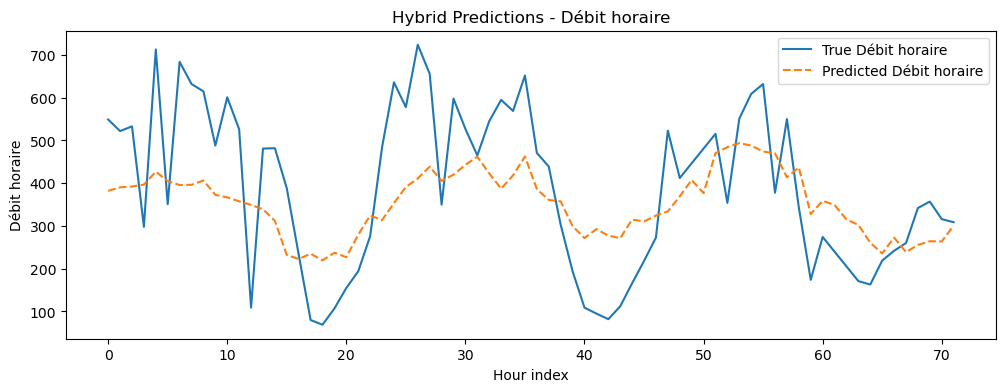

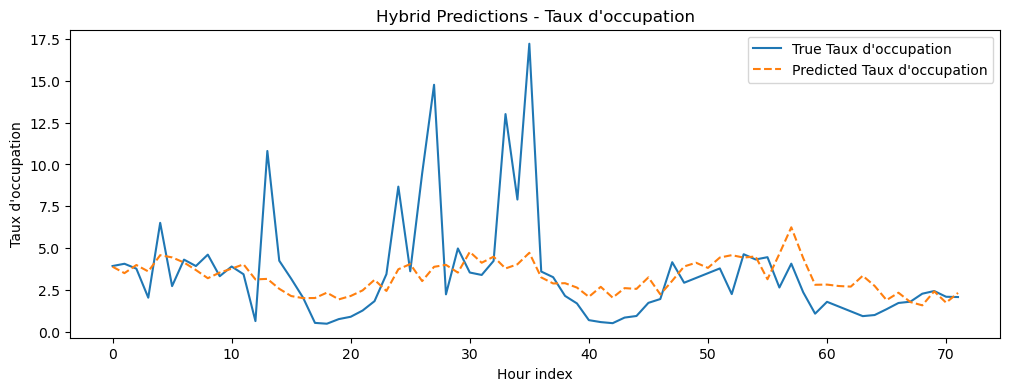

In [26]:
# Plot
for i, target in enumerate(targets):
    plt.figure(figsize=(12,4))
    plt.plot(y_test_inv[-1, :, :][:, i], label=f"True {target}")
    plt.plot(y_pred_final[:, i], '--', label=f"Predicted {target}")
    plt.title(f"Hybrid Predictions - {target}")
    plt.xlabel("Hour index")
    plt.ylabel(target)
    plt.legend()
    plt.show()